In [1]:
import os 
import pandas as pd
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

# This three librarios are from local
from log_parser_lib import *
from AB_score_lib import *
from LogNetconfAD_lib import *

import datetime

# Read and Parsing Netconf data 

In [2]:
netconf_file_path='../2401_log_netconf/ncclient/juniper'

In [3]:
file_list=os.listdir(netconf_file_path)
file_list.sort()
file_list

['.gitkeep',
 '2024-01-08T16-59-50.json',
 '2024-01-08T17-05-01.json',
 '2024-01-08T17-10-16.json',
 '2024-01-08T17-15-29.json',
 '2024-01-08T17-20-42.json',
 '2024-01-08T17-25-56.json',
 '2024-01-08T17-31-10.json',
 '2024-01-08T17-36-23.json',
 '2024-01-08T17-41-38.json',
 '2024-01-08T17-46-51.json',
 '2024-01-08T17-52-06.json',
 '2024-01-08T17-57-19.json',
 '2024-01-08T18-02-33.json',
 '2024-01-08T18-07-47.json',
 '2024-01-08T18-13-01.json',
 '2024-01-08T18-18-15.json',
 '2024-01-08T18-23-29.json',
 '2024-01-08T18-28-42.json',
 '2024-01-08T18-33-56.json',
 '2024-01-08T18-39-10.json',
 '2024-01-08T18-44-24.json',
 '2024-01-08T18-49-38.json',
 '2024-01-08T18-54-52.json',
 '2024-01-08T19-00-07.json',
 '2024-01-08T19-05-21.json',
 '2024-01-08T19-10-35.json',
 '2024-01-08T19-15-49.json',
 '2024-01-08T19-21-04.json',
 '2024-01-08T19-26-17.json',
 '2024-01-08T19-31-32.json',
 '2024-01-08T19-36-46.json',
 '2024-01-08T19-42-00.json',
 '2024-01-08T19-47-14.json',
 '2024-01-08T19-52-27.json',
 

In [4]:
def json_date_parsing(file_name):
    date_=datetime.datetime.strptime(file_name, '%Y-%m-%dT%H-%M-%S.json')
    return date_

In [5]:
json_date_parsing(file_list[1])

datetime.datetime(2024, 1, 8, 16, 59, 50)

In [6]:
def json_read_content(file_name):
    with open(file_name) as f:
        json_data=json.load(f)
    del json_data['time'], json_data['down-interfaces'], json_data['up-interfaces'], json_data['interface-information']
    stat=json_data['statistics']
    del json_data['statistics']
    for protocol in stat.keys():
        for key, value in stat[protocol].items():
            if type(value)==int and value!=0:
                json_data[protocol+'-'+key]=value
    #print(json_data.keys())
    json_data['cpu-util']=int(json_data['cpu-util'][:-1])
    json_data['mem-util']=int(json_data['mem-util'][:-1])
    json_data['chassi-temperature']=int(json_data['chassi-temperature'][:-1])
    return json_data

In [7]:
data=pd.DataFrame()
for single_file in file_list:
    if not single_file.endswith('.json'):
        continue
    file_date=json_date_parsing(single_file)
    file_content=json_read_content(netconf_file_path+'/'+single_file)
    data=data.append(pd.Series(file_content, name=file_date))

In [8]:
data

,chassi-temperature,cpu-util,mem-util,arp-arp-replies-sent,arp-arp-requests-received,arp-datagrams-received,icmp-calls-to-icmp-error,ip-incoming-ttpoip-packets-received,ip-outgoing-ttpoip-packets-sent,ip-output-packets-discarded-due-to-no-route,...,tcp-packets-received-after-close,tcp-connections-updated-rtt-on-close,tcp-connections-updated-variance-on-close,tcp-byte-retransmits,tcp-retransmit-timeouts,tcp-retransmitted-bytes,tcp-sack-options-received,tcp-sack-recovery-episodes,tcp-segment-retransmits,tcp-sent-data-packets-retransmitted
2024-01-08 16:59:50,40.0,23.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-08 17:05:01,40.0,22.0,16.0,10.0,10.0,10.0,139.0,3128.0,4310.0,192.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-08 17:10:16,40.0,20.0,16.0,12.0,12.0,12.0,142.0,2455.0,4131.0,200.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-08 17:15:29,40.0,20.0,16.0,12.0,12.0,12.0,137.0,2442.0,4453.0,193.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-08 17:20:42,40.0,21.0,16.0,11.0,11.0,11.0,138.0,2829.0,4494.0,196.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-24 20:42:24,40.0,21.0,18.0,13.0,13.0,14.0,136.0,3384.0,5225.0,3.0,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-24 20:47:37,40.0,17.0,18.0,13.0,13.0,13.0,142.0,5303.0,7493.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-24 20:52:52,40.0,21.0,18.0,9.0,9.0,9.0,138.0,3619.0,4816.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-24 20:58:06,40.0,21.0,18.0,11.0,11.0,11.0,135.0,2098.0,2794.0,NaN,...,NaN,1.0,1.0,9936.0,4.0,4344.0,424.0,6.0,20.0,3.0


In [9]:
# 항상 0인 column이 정상적으로 제거됐는지 확인
column_means=data.mean()
column_means[column_means==0].index

Index([], dtype='object')

In [10]:
split_timestamp=datetime.datetime(2024,1,16,12,0)
condition=data.index>=split_timestamp
data_no=data.loc[condition]
data_no.mean()

chassi-temperature                       41.108799
cpu-util                                 20.354573
mem-util                                 16.045080
arp-arp-replies-sent                      9.144343
arp-arp-requests-received                 9.144343
                                          ...     
tcp-retransmitted-bytes                4344.000000
tcp-sack-options-received               424.000000
tcp-sack-recovery-episodes                6.000000
tcp-segment-retransmits                  20.000000
tcp-sent-data-packets-retransmitted       3.000000
Length: 62, dtype: float64

In [11]:
condition=data.index<split_timestamp
data_ab=data.loc[condition]
data_ab.mean()

chassi-temperature                     41.231702
cpu-util                               20.494639
mem-util                               16.000000
arp-arp-replies-sent                    9.146922
arp-arp-requests-received               9.146922
                                         ...    
tcp-retransmitted-bytes                      NaN
tcp-sack-options-received                    NaN
tcp-sack-recovery-episodes                   NaN
tcp-segment-retransmits                      NaN
tcp-sent-data-packets-retransmitted          NaN
Length: 62, dtype: float64

In [12]:
len(data)

4452

# Test RNN only with Netconf data

Epoch [1/1000], Loss: 0.6746
Predciction accuracy is 0.38
F1 score is 0.47
11 corrects among 29 data
Epoch [51/1000], Loss: 0.5910
Predciction accuracy is 0.66
F1 score is 0.00
19 corrects among 29 data
Epoch [101/1000], Loss: 0.6981
Predciction accuracy is 0.66
F1 score is 0.00
19 corrects among 29 data
Epoch [151/1000], Loss: 0.7113
Predciction accuracy is 0.66
F1 score is 0.00
19 corrects among 29 data
Epoch [201/1000], Loss: 0.6038
Predciction accuracy is 0.66
F1 score is 0.00
19 corrects among 29 data
Epoch [251/1000], Loss: 0.6598
Predciction accuracy is 0.66
F1 score is 0.00
19 corrects among 29 data
Epoch [301/1000], Loss: 0.6586
Predciction accuracy is 0.66
F1 score is 0.00
19 corrects among 29 data
Epoch [351/1000], Loss: 0.7643
Predciction accuracy is 0.66
F1 score is 0.00
19 corrects among 29 data
Epoch [401/1000], Loss: 0.5970
Predciction accuracy is 0.66
F1 score is 0.00
19 corrects among 29 data
Epoch [451/1000], Loss: 0.6868
Predciction accuracy is 0.66
F1 score is 0.00

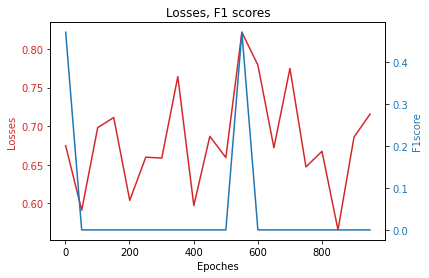

In [13]:
AD(data,freq='4H',lr=0.01, use_simple=False)

# Let's calculate IF-IDF now

In [14]:
with open('data.pkl','rb') as f:
    data_=pkl.load(f)
(log_dict, synant_dict, log_patterns,event_list),(Q, sigma, delta, initialState, F_) = data_
with open('tf_data.pkl', 'rb')as f:
    data_=pkl.load(f)
tf_idf, num_all_docs = data_
print(f'event num is {len(event_list)}')

EOFError: Ran out of input

In [ ]:
log_path='../2401_log_netconf/log'
log_data=pd.DataFrame()
norm_num=0
date_list=os.listdir(log_path)
                     
for date in date_list:
    if os.path.isfile(log_path+'/'+date) or date.startswith('06'):
        continue
    dir_list=os.listdir(log_path+'/'+date)
    single_log_data=[]
    mon=int(date[:2])
    day=int(date[3:])
    for dir_name in dir_list:
        file_list=os.listdir(log_path+'/'+date+'/'+dir_name)
        for file_name in file_list:
            #print(log_path+'/'+date+'/'+dir_name+'/'+file_name)
            log_=read_file(log_path+'/'+date+'/'+dir_name+'/'+file_name)
        if log_:
            single_log_data.extend(log_)
    df=pd.DataFrame(single_log_data)
    df['date']=df['date'].apply(lambda x: x.replace(year=2024, month=mon, day=day))
    df.set_index('date', inplace=True)
    log_data=pd.concat([log_data, df])
log_data=log_data.sort_index()

In [ ]:
tf_idf_results=calculate_abnormal_score_for_df(log_data,log_dict, log_patterns, event_list, tf_idf, num_all_docs)

In [ ]:
tf_idf_results

## Merge TF-IDF with NetConf

In [ ]:
def calculate_average_values(row_B, df_A, column_name, window_minutes):
    window_start = row_B.name - pd.Timedelta(minutes=window_minutes)
    window_end = row_B.name + pd.Timedelta(minutes=window_minutes)
    filtered_values = df_A[column_name].loc[(df_A.index >= window_start) & (df_A.index <= window_end)]
    if not filtered_values.empty:
        return filtered_values.mean()
    else:
        return None

In [ ]:
window_minutes = 10
for column_name, column in data.items():
    tf_idf_results['average_'+column_name]=tf_idf_results.apply(lambda row: calculate_average_values(row, data, column_name, window_minutes), axis=1)

In [ ]:
#merged_df=pd.merge_asof(data, tf_idf_results, left_index=True, right_index=True, tolerance=pd.Timedelta('5 minute'))

In [ ]:
tf_idf_results

In [ ]:
condition=tf_idf_results.index<split_timestamp
tf_ab=tf_idf_results.loc[condition]
tf_ab.mean()

In [ ]:
condition=tf_idf_results.index>=split_timestamp
tf_no=tf_idf_results.loc[condition]
tf_no.mean()

In [ ]:
tf_idf_results.mean()

## Test total data

In [ ]:
AD(tf_idf_results,freq='3H',lr=0.01)

In [ ]:
AD(tf_idf_results,freq='3H',lr=0.01, use_simple=False)